In [1]:
import sys
sys.path.append("../")
from matplotlib import pyplot as plt
from matplotlib.axes import Axes
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit
from axessettings import AxesSetting, linear_sim
import regex as re
import scipy.constants as const

In [2]:
gaps = [0.5, 1.5, 2.5, 5, 10]
data_spheres = {gap: pd.read_excel("data_pc2.xlsx", f"gap={gap}mm") for gap in gaps}
data_spheres

{0.5:       No.    r[cm]    z[cm]    V[kV]  Er[kV/cm]  Ez[kV/cm]  |E| [kV/cm]
 0       1  0.00000  0.05000  1.00000    0.00000  -20.45113     20.45113
 1       1  0.00000  0.04951  0.99000    0.00000  -20.43764     20.43764
 2       1  0.00000  0.04902  0.98000    0.00000  -20.42429     20.42429
 3       1  0.00000  0.04853  0.97000    0.00000  -20.41108     20.41108
 4       1  0.00000  0.04804  0.96000    0.00000  -20.39801     20.39801
 ...   ...      ...      ...      ...        ...        ...          ...
 1317   13  4.63980  0.46746  0.03131    0.01875   -0.06530      0.06794
 1318   13  4.67525  0.32304  0.02132    0.01274   -0.06522      0.06646
 1319   13  4.69828  0.17330  0.01133    0.00676   -0.06516      0.06551
 1320   13  4.70782  0.02049  0.00133    0.00079   -0.06512      0.06513
 1321   13  4.70802  0.00000  0.00000    0.00000   -0.06512      0.06512
 
 [1322 rows x 7 columns],
 1.5:       No.    r[cm]    z[cm]    V[kV]  Er[kV/cm]  Ez[kV/cm]  |E| [kV/cm]
 0       1  0

In [3]:
TORR_PA = 133.322
P_PA = 1000
V = 1
P_TORR = P_PA / TORR_PA
K = 10

In [4]:
def has_spark(data_gap: pd.DataFrame, V, p):
    return any(get_K_line(line, V, p)*2 >= K for line_index, line in data_gap.groupby("No."))
    return any(K_calc >= K for K_calc in get_K(data_gap, V, p))


# V in kV, p in Torr, E in V/cm
def get_K(data_gap: pd.DataFrame, V, p):
    return [2*get_K_line(line, V, p) for line_index, line in data_gap.groupby("No.")]

def get_K_line(data_line: pd.DataFrame, V, p):
    arr_alpha = valpha(data_line["|E| [kV/cm]"]*V*1000, p)
    return linear_calculus(data_line[["r[cm]", "z[cm]"]].to_numpy(), arr_alpha)
    
def linear_calculus(coords, values):
    assert len(coords) == len(values)
    sum = 0
    for i in range(len(coords)-1):
        sum += np.sqrt((coords[i+1][0]-coords[i][0])**2+(coords[i+1][1]-coords[i][1])**2) * (values[i]+values[i+1])/2
    return sum

def alpha(E, p):
    Edp = E/p
    if Edp < 31.6:
        return 0
    elif Edp < 60.0:
        return p/10000*(1.047*(Edp-28.5)**2-12.6)
    elif Edp < 100.0:
        return (1-0.00674755*(Edp-60))*p/10000*(1.047*(Edp-28.5)**2-12.6)
    else:
        return 15.0*p*np.exp(-365/Edp)

valpha = np.vectorize(alpha, excluded=["p"])

In [5]:
def binary_search(Vmin, Vmax, data_gap, p):
    V_pivot = (Vmin+Vmax)/2
    if Vmax-Vmin < 0.005:
        return V_pivot
    is_spark_pivot = has_spark(data_gap, V_pivot, p)
    if (is_spark_pivot):
        return binary_search(Vmin, V_pivot, data_gap, p)
    else:
        return binary_search(V_pivot, Vmax, data_gap, p)

gap=0.5mm, p=1Torr, V=0.36468505859375kV: [1.4728706662510602, 1.5042025222591362, 1.6000502182737697, 1.7728249638321933, 2.048875377282796, 2.4768878039992974, 3.1437486231562493, 4.217082315370247, 6.025000151103575, 9.227761942892254, 15.083341101508111, 24.1705372024835, 22.664610393007365]
Calculated 0.5
gap=1.5mm, p=1Torr, V=0.34027099609375kV: [4.26005456092309, 4.294490302812526, 4.398236295926354, 4.5758504368305815, 4.836801652666385, 5.19571013173514, 5.6726049618045415, 6.299436569590312, 7.116410548296109, 8.1855857842881, 9.585477078646445, 11.424992579576095, 13.837681608800573, 16.945105121996402, 20.72254484831357, 24.559978723759297, 26.359609922247696, 23.735360962281568, 21.219191599882]
Calculated 1.5
gap=2.5mm, p=1Torr, V=0.33721923828125kV: [6.844531134206959, 6.881358310382875, 6.992462368290904, 7.180110344362103, 7.451338990496272, 7.814564400191616, 8.281803320511017, 8.870844392679347, 9.602159943613518, 10.504234004915633, 11.608839924619343, 12.9561297872

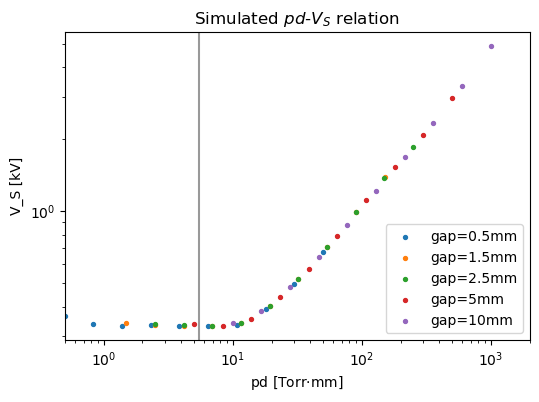

In [6]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
axstg = AxesSetting("Simulated $pd$-$V_S$ relation", "pd [Torr$\cdot$mm]", "V_S [kV]", xscale="log", yscale="log", xlim=(5e-1, 2e3))
coords = []
for gap in gaps:
    p_check = np.geomspace(1, 100, 10)
    v_sparks = [binary_search(0, 50, data_spheres[gap], p) for p in p_check]
    print(f"{gap=}mm, p=1Torr, V={v_sparks[0]}kV: {[get_K_line(line, V, 1)*2 for _, line in data_spheres[gap].groupby('No.')]}")
    ax.scatter(p_check*gap, v_sparks, label=f"gap={gap}mm", s=8)
    coords += [[gap, p_check[i], v_sparks[i]] for i in range(len(p_check))]
    print(f"Calculated {gap}")
df_theory = pd.DataFrame(data=coords, columns=["d", "p", "V"])
df_theory["dp"] = df_theory["p"] * df_theory["d"]
df_theory.sort_values("dp", inplace=True)
# ax.plot(df_theory["dp"], df_theory["V"], zorder=-2, c="black", alpha=0.4)
ax.axvline(5.5, c="black", alpha=0.4)
axstg.apply_axes(ax)


In [7]:
df_theory.to_csv("theoretical.csv", index=False)

In [13]:
df_cone = pd.read_excel("data_pc2.xlsx", "円錐gap=10mm")
V_Scone = binary_search(0, 100, df_cone, 760)
V_Scone

9.41925048828125

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


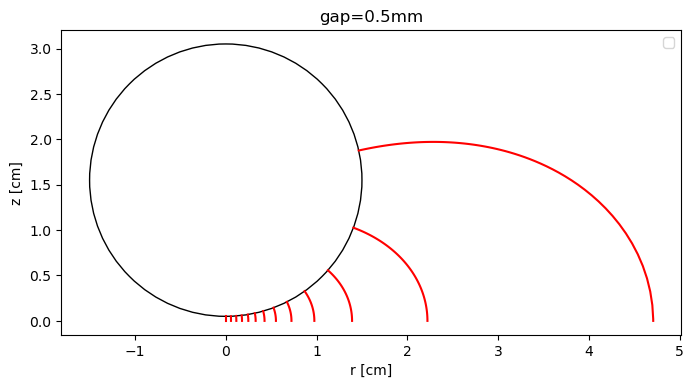

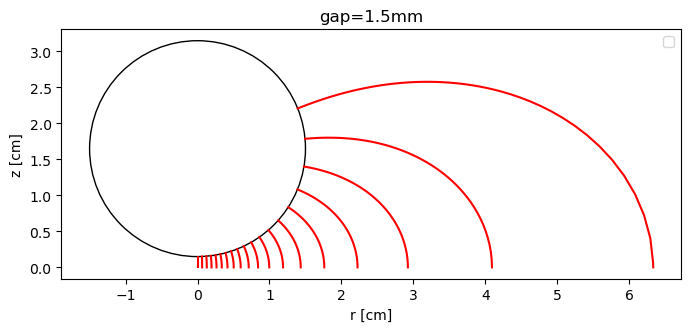

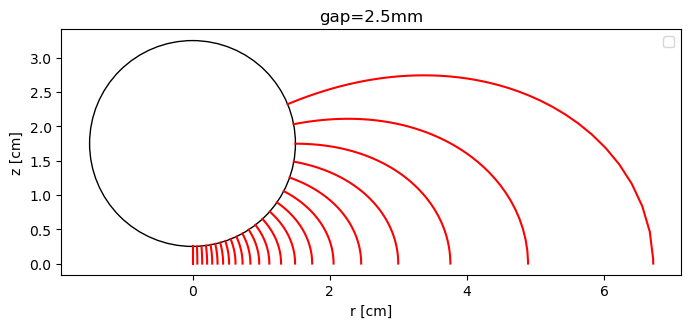

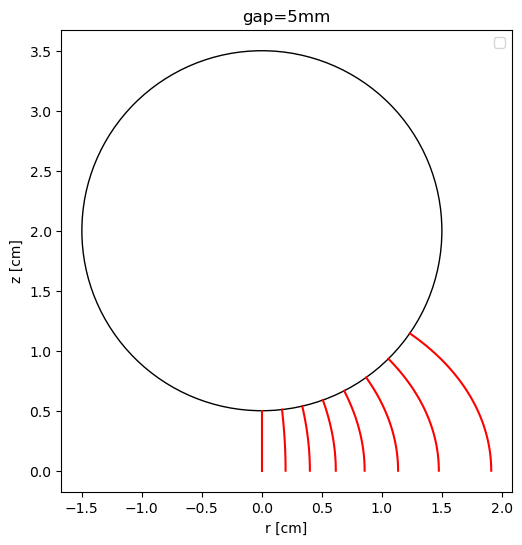

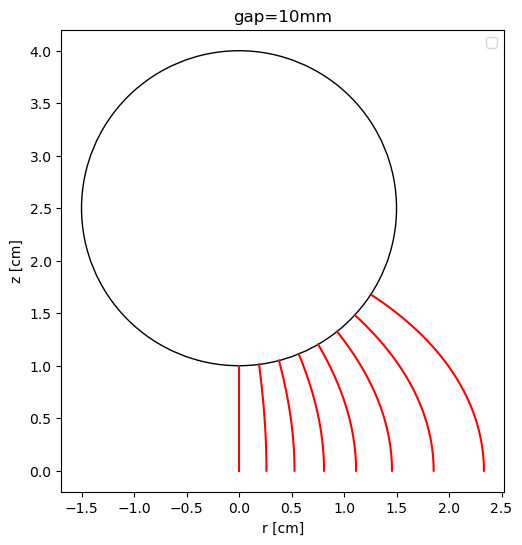

In [8]:
for gap in gaps:
    fig, ax = plt.subplots(1, 1, figsize=(8, 6))
    axstg = AxesSetting(f"gap={gap}mm", "r [cm]", "z [cm]", aspect=1)
    for i, line in data_spheres[gap].groupby("No."):
        ax.plot(line["r[cm]"], line["z[cm]"], linestyle="-", c="red")
    ax.add_patch(plt.Circle((0, gap/10+1.5), 1.5, fill=False, ec="black"))
    axstg.apply_axes(ax)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


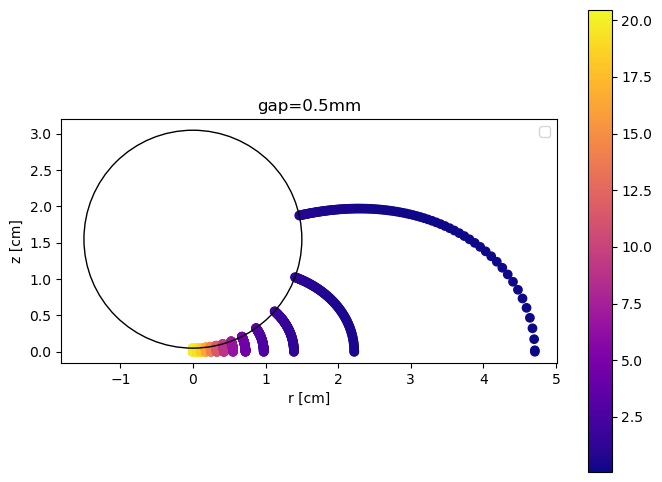

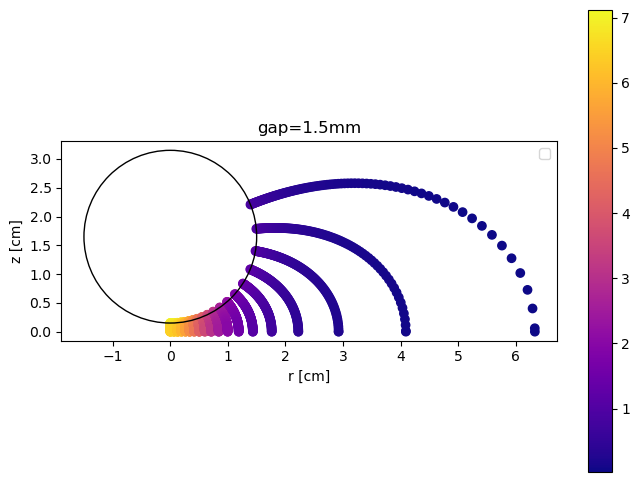

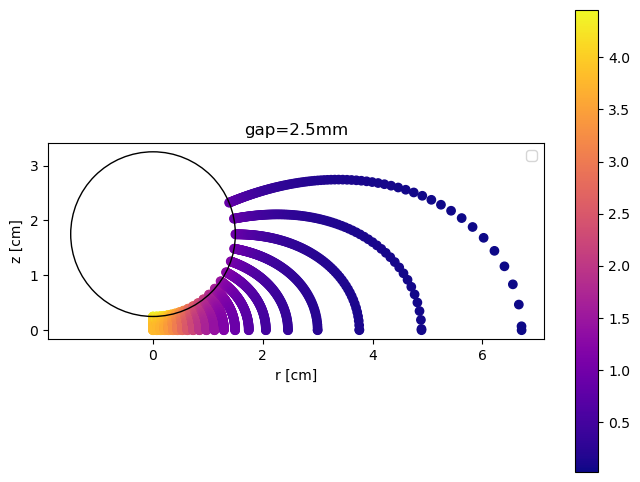

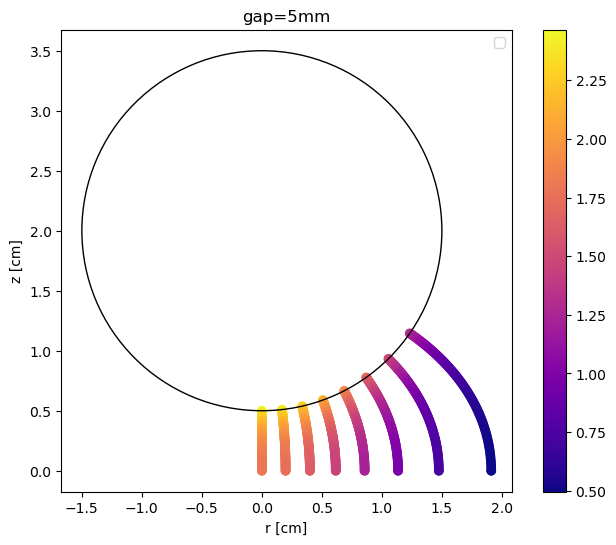

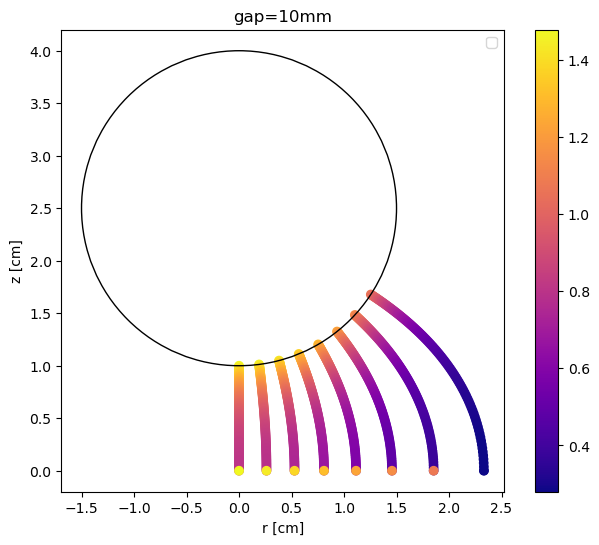

In [9]:
for gap in gaps:
    fig, ax = plt.subplots(1, 1, figsize=(8, 6))
    axstg = AxesSetting(f"gap={gap}mm", "r [cm]", "z [cm]", aspect=1)
    sc = ax.scatter(data_spheres[gap]["r[cm]"], data_spheres[gap]["z[cm]"], c=data_spheres[gap]["|E| [kV/cm]"], cmap="plasma")
    ax.add_patch(plt.Circle((0, gap/10+1.5), 1.5, fill=False, ec="black"))
    axstg.apply_axes(ax)
    fig.colorbar(sc)